Calculates the cost of running the BIG-bench evaluation suite against public LM model API's.

It uses the same selection of queries used in the original paper.

In [31]:
import lass.datasets
import lass.pipeline
from lass.log_handling import LogLoader, PaperTasks

from datasets.arrow_dataset import Dataset
from transformers.models.auto.tokenization_auto import AutoTokenizer

In [2]:
loader = LogLoader(
    logdir="../artifacts/logs",
    tasks="paper-full",
    model_families=["BIG-G T=0"],
    model_sizes=["128b"],
    include_unknown_shots=True,
    shots=None,  # all
    query_types=None,  # all
)
data = lass.datasets.to_dataframe(loader)


In [16]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
def token_length(examples):
    batch = tokenizer(
        examples["text"],
        padding=False,
        truncation=True,
        max_length=1024,
        return_tensors="np"
    )
    lengths = [len(seq) for seq in batch["input_ids"]]
    return {"n_tokens": lengths}

hfdata = lass.pipeline.huggingfaceify(data)
hfddataset = Dataset.from_pandas(hfdata, preserve_index=False)
lengths = hfddataset.map(token_length, batched=True)
data['n_tokens'] = lengths['n_tokens']

  0%|          | 0/522 [00:00<?, ?ba/s]

/home/wout/pp/lass/.env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


<AxesSubplot:>

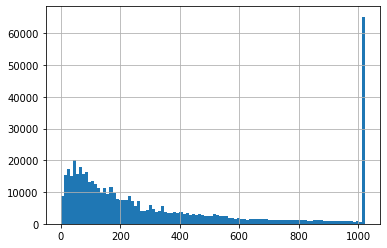

In [23]:
data.n_tokens.hist(bins=100)

In [33]:
def calc(data):
    n_input_tokens = data.n_tokens.sum()
    n_output_tokens = len(data) * 64 # This is bigbench configured max output length
    n_tokens_total = n_input_tokens + n_output_tokens

    print(f"Total number of tokens: {n_tokens_total:,}")
    def calc_price(price_per_thousand_tokens, model_name):
        price_total = price_per_thousand_tokens * n_tokens_total / 1000
        print(f"Total price for {model_name} (${price_per_thousand_tokens} / 1000 tokens): {price_total:.2f}")
        return price_total

    prices = [
        calc_price(0.0004, "Ada"),
        calc_price(0.0005, "Babbage"),
        calc_price(0.0020, "Curie"),
        calc_price(0.0200, "Davinci"),
    ]

    print(f"Price for all models: {sum(prices):.2f}")

calc(data)
print("-----------")
calc(data[data.task.isin(PaperTasks.lite())])

Total number of tokens: 213,186,682
Total price for Ada ($0.0004 / 1000 tokens): 85.27
Total price for Babbage ($0.0005 / 1000 tokens): 106.59
Total price for Curie ($0.002 / 1000 tokens): 426.37
Total price for Davinci ($0.02 / 1000 tokens): 4263.73
Price for all models: 4881.98
-----------
Total number of tokens: 29,601,537
Total price for Ada ($0.0004 / 1000 tokens): 11.84
Total price for Babbage ($0.0005 / 1000 tokens): 14.80
Total price for Curie ($0.002 / 1000 tokens): 59.20
Total price for Davinci ($0.02 / 1000 tokens): 592.03
Price for all models: 677.88
